In [1]:
import os 
import glob
from pathlib import Path
from rtmag.paper.parse import parse_tai_string
from sunpy.map import Map
import numpy as np
from skimage.transform import resize
from rtmag.paper.load import load_input_label, MyModel
from rtmag.paper.metric import energy
import matplotlib.pyplot as plt

from streamtracer import StreamTracer, VectorGrid
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import astropy.units as u
from astropy.time import Time
from time import time
from sunpy.map import Map
from matplotlib.ticker import MultipleLocator

import rtmag.paper.metric as m
from rtmag.paper.load import load_input_label, MyModel
from rtmag.paper.metric import vector_norm, current_density, curl

from rtmag.paper.vtk import save_vtk, save_vtk_xyz

from rtmag.paper.vista import create_mesh, create_coordinates

import pyvista as pv

In [2]:
mm = MyModel("/home/mgjeon/space/workspace/base/uno_pi_cc_hnorm_unit_aug/model_75.pt")

Model loaded from epoch 75


In [3]:
hmi_path = "/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_sharp/download/10976/hmi"

aia_path = "/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_sharp/download/10976/aia"

In [4]:
hmi_path = Path(hmi_path)
aia_path = Path(aia_path)

In [5]:
hmi_p_files = sorted(hmi_path.glob('*Bp.fits')) # x
hmi_t_files = sorted(hmi_path.glob('*Bt.fits')) # y
hmi_r_files = sorted(hmi_path.glob('*Br.fits')) # z
hmi_paths = list(zip(hmi_p_files, hmi_t_files, hmi_r_files))

In [6]:
ix = 0
data_path = hmi_paths[ix]
data_path

(PosixPath('/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_sharp/download/10976/hmi/hmi.sharp_cea_720s.10976.20240323_184800_TAI.Bp.fits'),
 PosixPath('/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_sharp/download/10976/hmi/hmi.sharp_cea_720s.10976.20240323_184800_TAI.Bt.fits'),
 PosixPath('/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_sharp/download/10976/hmi/hmi.sharp_cea_720s.10976.20240323_184800_TAI.Br.fits'))

In [7]:
hmi_Bp_map = Map(data_path[0])
hmi_Bt_map = Map(data_path[1])
hmi_Br_map = Map(data_path[2])

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


In [8]:
hmi_p, hmi_t, hmi_r = hmi_Bp_map, hmi_Bt_map, hmi_Br_map
p_map, t_map, r_map = Map(hmi_p), Map(hmi_t), Map(hmi_r)
maps = [p_map, t_map, r_map]
hmi_data = np.stack([maps[0].data, -maps[1].data, maps[2].data]).transpose()
hmi_data = np.nan_to_num(hmi_data, nan=0.0)
hmi_data = hmi_data.astype(np.float32)

hmi_data.shape

(1119, 721, 3)

In [9]:
ox, oy, _ = hmi_data.shape
nx, ny = 512, 256

l = 0.36 # Mm

dx = ((ox - 1)/(nx - 1))*l
dy = ((oy - 1)/(ny - 1))*l
dz = dy 

print(f"dx = {dx} Mm")
print(f"dy = {dy} Mm")
print(f"dz = {dz} Mm")

dx, dy, dz = dx * 1e8, dy * 1e8, dz * 1e8  # cm
dV = dx * dy * dz # cm^3



model_input = resize(hmi_data, (nx, ny, 3))
model_input = model_input[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4)
model_input.shape

dx = 0.7876320939334638 Mm
dy = 1.0164705882352942 Mm
dz = 1.0164705882352942 Mm


(1, 1, 256, 512, 3)

In [10]:
b = mm.get_pred_from_numpy(model_input)

In [11]:
b.dtype

dtype('float32')

In [12]:
x = np.linspace(0, (ox-1)*l, nx)
y = np.linspace(0, (oy-1)*l, ny)
z = y

In [13]:
save_vtk_xyz(b, x, y, z, '10976_20240323_184800.vtk')

10976_20240323_184800.vtk already exists


In [14]:
aia_94_files = sorted(aia_path.glob('**/94/*.fits'))
aia_131_files = sorted(aia_path.glob('**/131/*.fits'))
aia_171_files = sorted(aia_path.glob('**/171/*.fits'))
aia_193_files = sorted(aia_path.glob('**/193/*.fits'))
aia_211_files = sorted(aia_path.glob('**/211/*.fits'))
aia_304_files = sorted(aia_path.glob('**/304/*.fits'))
aia_335_files = sorted(aia_path.glob('**/335/*.fits'))

In [15]:
aia_94_map = Map(aia_94_files[ix])
aia_131_map = Map(aia_131_files[ix])
aia_171_map = Map(aia_171_files[ix])
aia_193_map = Map(aia_193_files[ix])
aia_211_map = Map(aia_211_files[ix])
aia_304_map = Map(aia_304_files[ix])
aia_335_map = Map(aia_335_files[ix])

In [16]:
new_dimensions = [512, 256] * u.pixel

hmi_Bp_resampled_map = hmi_Bp_map.resample(new_dimensions)
hmi_Bt_resampled_map = hmi_Bt_map.resample(new_dimensions)
hmi_Br_resampled_map = hmi_Br_map.resample(new_dimensions)

# hmi_Bp_map_data = resize(hmi_Bp_map.data, (256, 512))
# hmi_Bt_map_data = resize(hmi_Bt_map.data, (256, 512))
# hmi_Br_map_data = resize(hmi_Br_map.data, (256, 512))

aia_94 = aia_94_map.reproject_to(hmi_Br_map.wcs)
aia_131 = aia_131_map.reproject_to(hmi_Br_map.wcs)
aia_171 = aia_171_map.reproject_to(hmi_Br_map.wcs)
aia_193 = aia_193_map.reproject_to(hmi_Br_map.wcs)
aia_211 = aia_211_map.reproject_to(hmi_Br_map.wcs)
aia_304 = aia_304_map.reproject_to(hmi_Br_map.wcs)
aia_335 = aia_335_map.reproject_to(hmi_Br_map.wcs)

# aia_94_data = resize(aia_94.data, (256, 512))
# aia_131_data = resize(aia_131.data, (256, 512))
# aia_171_data = resize(aia_171.data, (256, 512))
# aia_193_data = resize(aia_193.data, (256, 512))
# aia_211_data = resize(aia_211.data, (256, 512))
# aia_304_data = resize(aia_304.data, (256, 512))
# aia_335_data = resize(aia_335.data, (256, 512))

aia_94_resampled_map = aia_94.resample(new_dimensions)
aia_131_resampled_map = aia_131.resample(new_dimensions)
aia_171_resampled_map = aia_171.resample(new_dimensions)
aia_193_resampled_map = aia_193.resample(new_dimensions)
aia_211_resampled_map = aia_211.resample(new_dimensions)
aia_304_resampled_map = aia_304.resample(new_dimensions)
aia_335_resampled_map = aia_335.resample(new_dimensions)

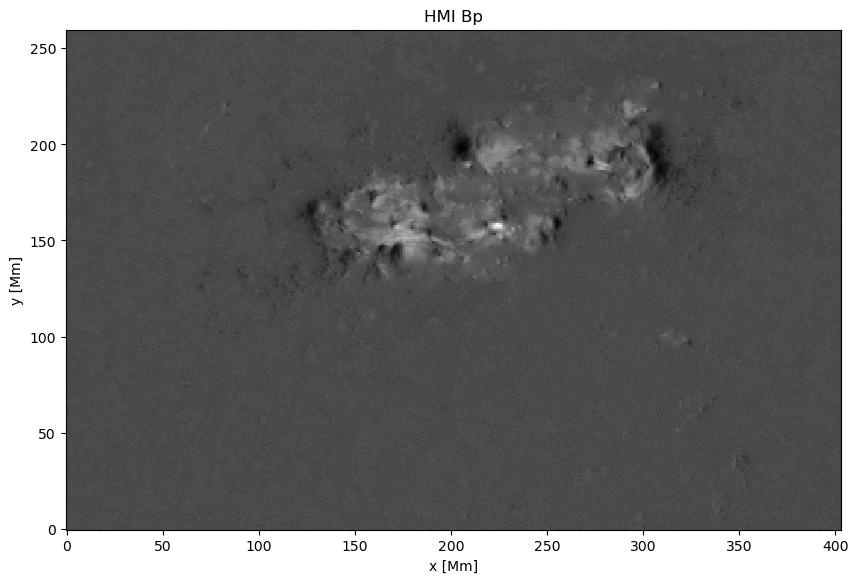

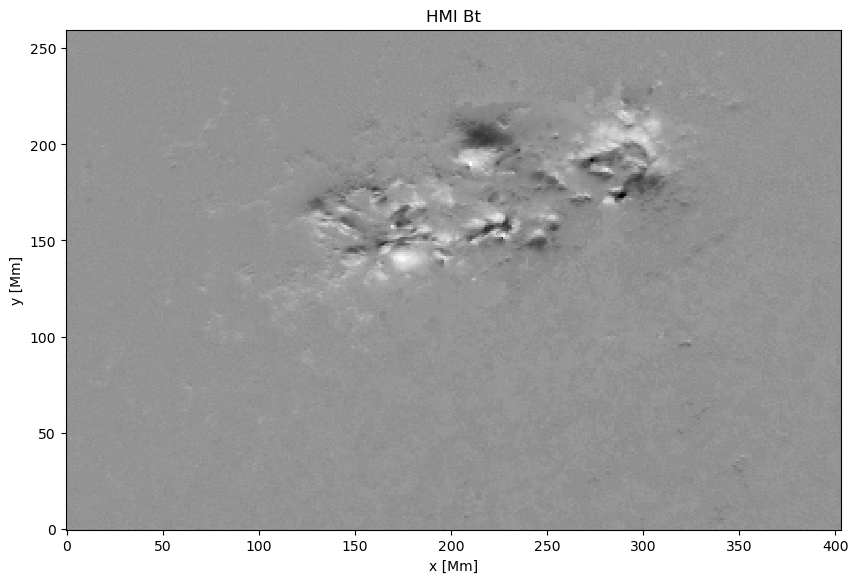

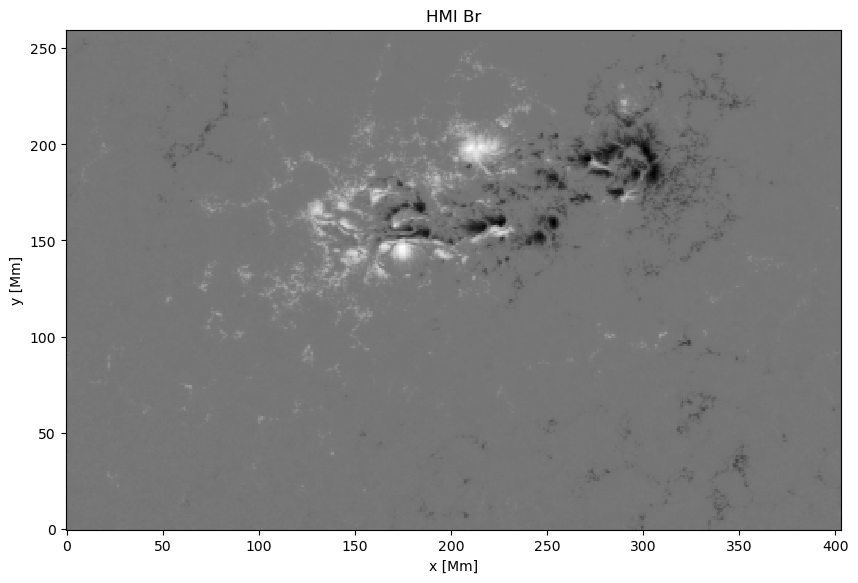

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, hmi_Bp_resampled_map.data, 
              cmap = hmi_Bp_map.plot_settings['cmap'], 
              norm = hmi_Bp_map.plot_settings['norm'])
ax.set_aspect('equal')
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_title('HMI Bp')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, hmi_Bt_resampled_map.data, 
              cmap = hmi_Bt_map.plot_settings['cmap'], 
              norm = hmi_Bt_map.plot_settings['norm'])
ax.set_aspect('equal')
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_title('HMI Bt')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, hmi_Br_resampled_map.data, 
              cmap = hmi_Br_map.plot_settings['cmap'], 
              norm = hmi_Br_map.plot_settings['norm'])
ax.set_aspect('equal')
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_title('HMI Br')
plt.show()

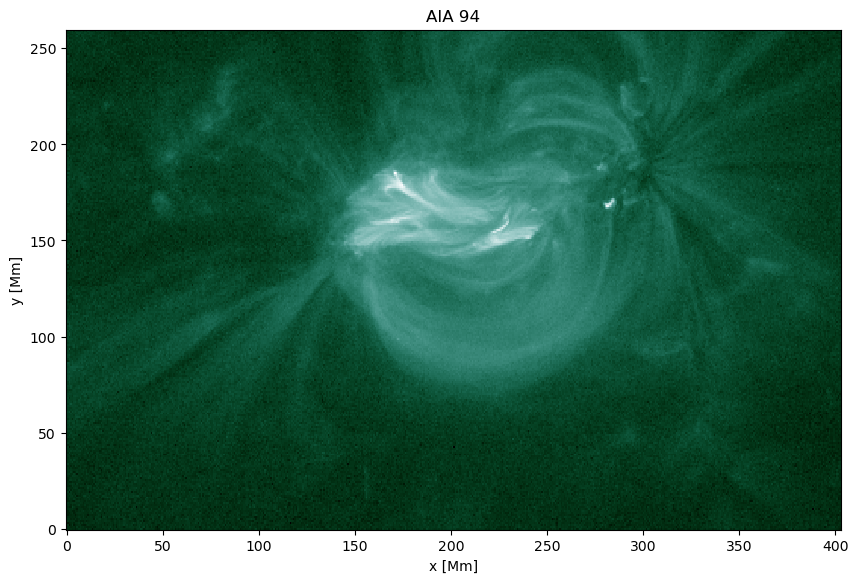

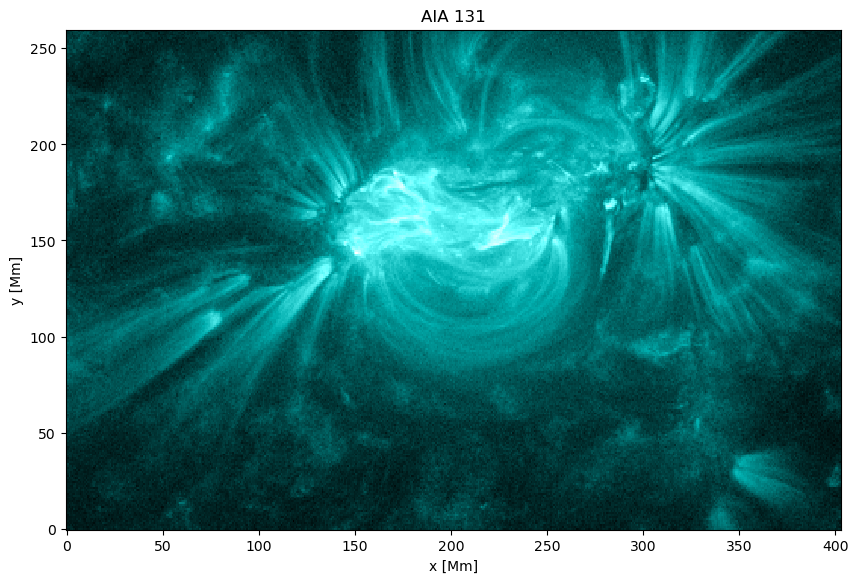

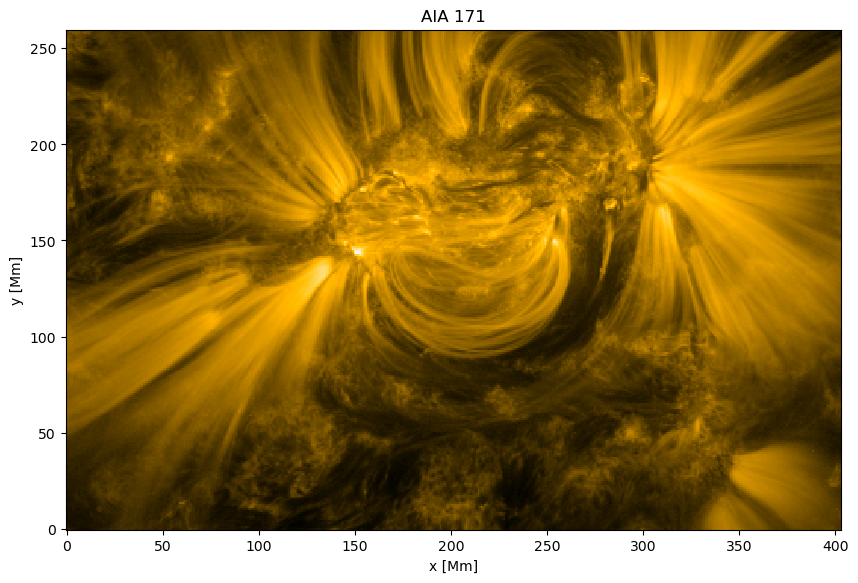

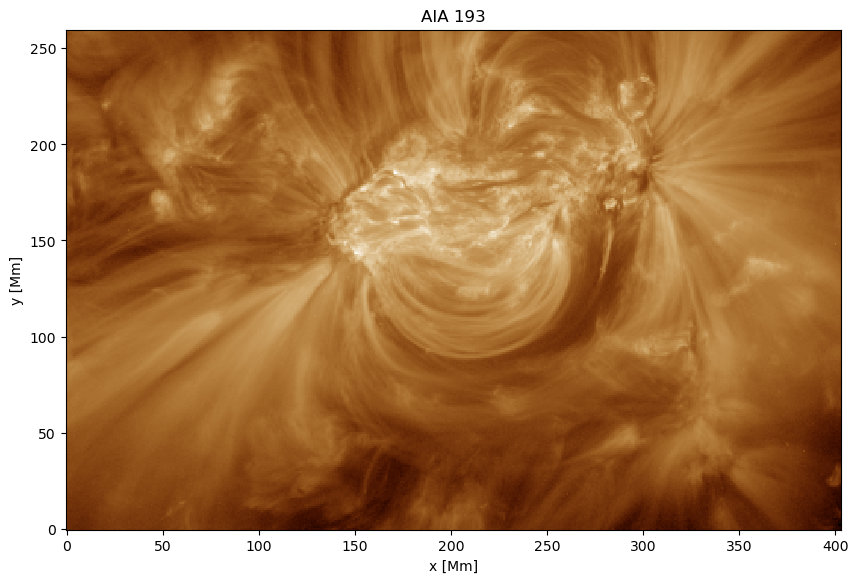

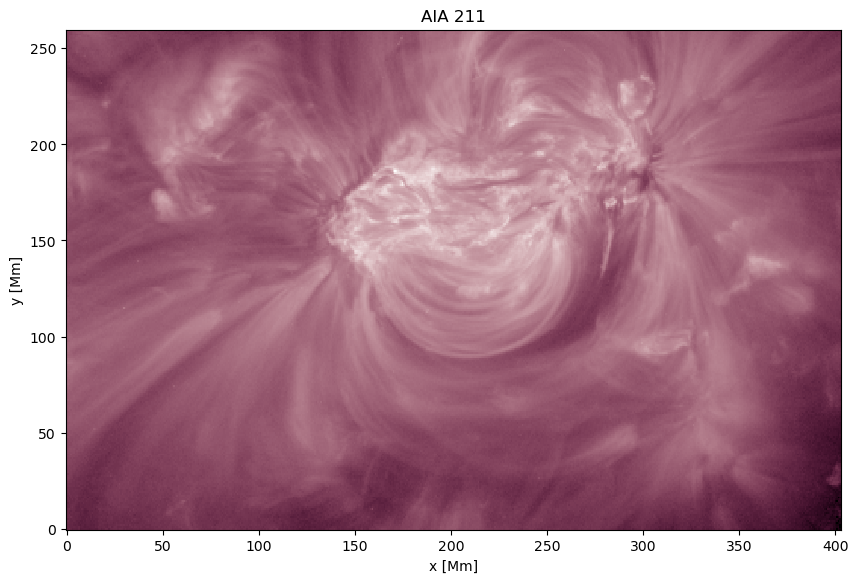

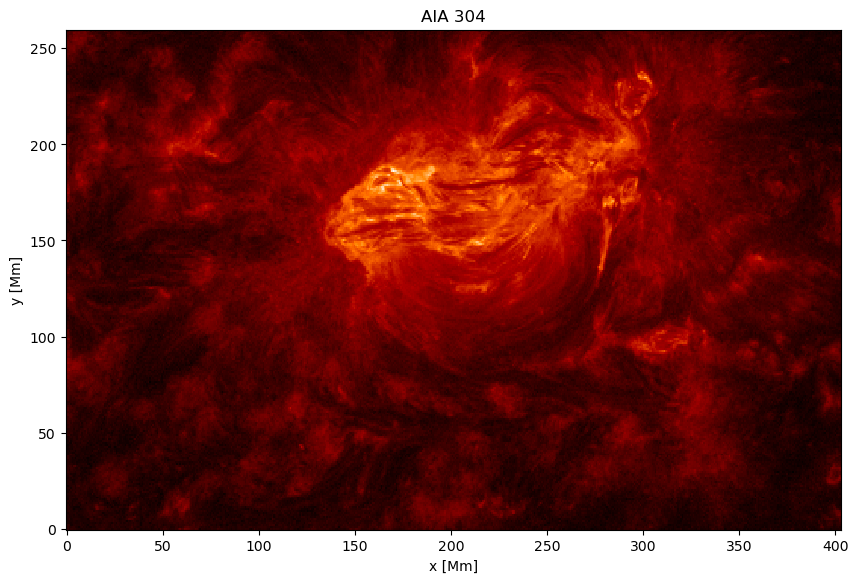

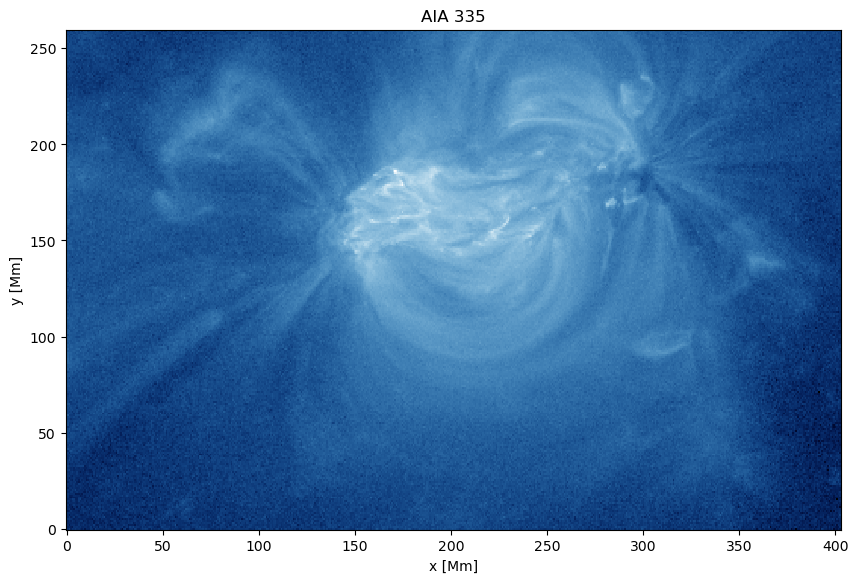

In [18]:
# AIA 94
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, aia_94_resampled_map.data, 
              cmap = aia_94_resampled_map.plot_settings['cmap'], 
              norm = aia_94_resampled_map.plot_settings['norm'])
ax.set_aspect('equal')
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_title('AIA 94')
plt.show()

# AIA 131
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, aia_131_resampled_map.data, 
              cmap = aia_131_resampled_map.plot_settings['cmap'], 
              norm = aia_131_resampled_map.plot_settings['norm'])
ax.set_aspect('equal')
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_title('AIA 131')
plt.show()

# AIA 171
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, aia_171_resampled_map.data, 
              cmap = aia_171_resampled_map.plot_settings['cmap'], 
              norm = aia_171_resampled_map.plot_settings['norm'])
ax.set_aspect('equal')
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_title('AIA 171')
plt.show()

# AIA 193
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, aia_193_resampled_map.data, 
              cmap = aia_193_resampled_map.plot_settings['cmap'], 
              norm = aia_193_resampled_map.plot_settings['norm'])
ax.set_aspect('equal')
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_title('AIA 193')
plt.show()

# AIA 211
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, aia_211_resampled_map.data, 
              cmap = aia_211_resampled_map.plot_settings['cmap'], 
              norm = aia_211_resampled_map.plot_settings['norm'])
ax.set_aspect('equal')
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_title('AIA 211')
plt.show()

# AIA 304
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, aia_304_resampled_map.data, 
              cmap = aia_304_resampled_map.plot_settings['cmap'], 
              norm = aia_304_resampled_map.plot_settings['norm'])
ax.set_aspect('equal')
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_title('AIA 304')
plt.show()

# AIA 335
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, aia_335_resampled_map.data, 
              cmap = aia_335_resampled_map.plot_settings['cmap'], 
              norm = aia_335_resampled_map.plot_settings['norm'])
ax.set_aspect('equal')
ax.set_xlabel('x [Mm]')
ax.set_ylabel('y [Mm]')
ax.set_title('AIA 335')
plt.show()

In [20]:
reader = pv.get_reader('10976_20240323_184800.vtk')

In [21]:
mesh = reader.read()

In [22]:
Lx = b.shape[0]
Ly = b.shape[1]

numbers = 20

# xmin, xmax, ymin, ymax
xyranges = [
    [0.30, 0.35, 0.50, 0.55],
    [0.45, 0.50, 0.60, 0.65],
    [0.65, 0.70, 0.70, 0.80],
    [0.35, 0.40, 0.30, 0.35],
    [0.35, 0.40, 0.40, 0.45],
    [0.30, 0.35, 0.30, 0.35],
    [0.70, 0.75, 0.70, 0.75],
    [0.32, 0.35, 0.40, 0.45],
]

seeds_xs = []

for xyrange in xyranges:

    xrange = np.array(xyrange[:2]) * Lx
    yrange = np.array(xyrange[2:]) * Ly

    np.random.seed(0)
    seeds = np.random.rand(numbers, 3) * [1, 1, 0]
    # seeds = np.stack([np.linspace(0, 1, numbers), np.linspace(0, 1, numbers), np.linspace(0, 1, numbers)], axis=-1) * [1, 1, 0]
    seeds[:, 0] = seeds[:, 0] * (xrange[1] - xrange[0]) + xrange[0]
    seeds[:, 1] = seeds[:, 1] * (yrange[1] - yrange[0]) + yrange[0]
    seeds_xs.append(seeds)

seeds_xs = np.vstack(seeds_xs)

In [23]:
p = pv.Plotter(window_size=(1000, 600))
p.add_mesh(mesh.outline())
seed = pv.PolyData(seeds_xs)
# p.add_mesh(seed, color='blue', point_size=3)
strl = mesh.streamlines_from_source(seed,
                                    vectors='vector',
                                    max_time=10000,
                                    initial_step_length=0.1,
                                    integration_direction='both')
x_ind_min, y_ind_min, z_ind_min = 0, 0, 0
Nx, Ny, Nz = mesh.dimensions
x_ind_max, y_ind_max, z_ind_max = Nx-1, Ny-1, Nz-1
bottom_subset = (x_ind_min, x_ind_max, y_ind_min, y_ind_max, 0, 0)
vmin, vmax = -2500, 2500
dargs_B = dict(
        scalars='vector', 
        component=2, 
        clim=(vmin, vmax), 
        scalar_bar_args=dict(
            title='Bz [G]',
            title_font_size=15,
            height=0.25,
            width=0.05,
            vertical=True,
            position_x = 0.05,
            position_y = 0.05,
        ),
        show_scalar_bar=False, 
        lighting=False
    )
bottom = mesh.extract_subset(bottom_subset).extract_surface()
p.add_mesh(strl.tube(radius=1), 
           cmap=pv.LookupTable(cmap='jet', scalar_range=(1, 5), log_scale=True), 
           scalars='current_density_magnitude',
           scalar_bar_args=dict(title="Current Density [mA/m^2]"))
p.add_mesh(bottom, cmap='gray', **dargs_B)
p.camera_position = "xy"
p.camera.zoom(1.3)
p.show(jupyter_backend="trame")

Widget(value='<iframe src="http://localhost:37121/index.html?ui=P_0x7f728c0a6e20_0&reconnect=auto" class="pyvi…